# Detection Accuracy
### Privacy Advocates, EECS504 F20
Thomas Cope, Sean Higgins, John Gearig, James Wegienka  <br />
Updated: 12 Dec 20

### Instructions: 
To test a new dataset, you must get the image names and bounding box statistics. To do this, simply change the "group" input to the `get_data()` function to the specific name of the group. For example, to pull images from the folder with pictures from demonstrations set `group = "Demonstration"`

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from validation_functions import *
import tensorflow as tf
from custom_cnn import *
from custom_cascade import *
from strict_cascade import *

c:\users\james\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\james\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\james\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\james\anaconda3\envs\tensorflow\lib\site-packages

## Cascade Classifier Code

In [2]:
from viola_jones import ViolaJones
import pickle
"""
A Python implementation of the "Attentional Cascade" mentioned in 
Viola, Paul, and Michael Jones. "Rapid object detection using a boosted cascade of simple features." Computer Vision and Pattern Recognition, 2001. CVPR 2001. Proceedings of the 2001 IEEE Computer Society Conference on. Vol. 1. IEEE, 2001.
Works in both Python2 and Python3
"""
# NOTE: THIS IS NOT OUR CODE, this is code from aparande's FaceDetection github
class CascadeClassifier():
    def __init__(self, layers):
        self.layers = layers
        self.clfs = []

    def train(self, training):
        pos, neg = [], []
        for ex in training:
            if ex[1] == 1:
                pos.append(ex)
            else:
                neg.append(ex)
        
        for feature_num in self.layers:
            if len(neg) == 0:
                print("Stopping early. FPR = 0")
                break
            clf = ViolaJones(T=feature_num)
            clf.train(pos+neg, len(pos), len(neg))
            self.clfs.append(clf)
            false_positives = []
            for ex in neg:
                if self.classify(ex[0]) == 1:
                    false_positives.append(ex)
            neg = false_positives

    def classify(self, image):
        for clf in self.clfs:
            if clf.classify(image) == 0:
                return 0
        return 1

    def save(self, filename):
        """
        Saves the classifier to a pickle
          Args:
            filename: The name of the file (no file extension necessary)
        """
        with open(filename+".pkl", 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load(filename):
        """
        A static method which loads the classifier from a pickle
          Args:
            filename: The name of the file (no file extension necessary)
        """
        with open(filename+".pkl", 'rb') as f:
            return pickle.load(f)

## Viola Jones Code

In [3]:
"""
A Python implementation of the Viola-Jones ensemble classification method described in 
Viola, Paul, and Michael Jones. "Rapid object detection using a boosted cascade of simple features." Computer Vision and Pattern Recognition, 2001. CVPR 2001. Proceedings of the 2001 IEEE Computer Society Conference on. Vol. 1. IEEE, 2001.
Works in both Python2 and Python3
"""
import numpy as np
import math
import pickle
from sklearn.feature_selection import SelectPercentile, f_classif
# NOTE: THIS IS NOT OUR CODE, this is code from aparande's FaceDetection github
class ViolaJones:
    def __init__(self, T = 10):
        """
          Args:
            T: The number of weak classifiers which should be used
        """
        self.T = T
        self.alphas = []
        self.clfs = []

    def train(self, training, pos_num, neg_num):
        """
        Trains the Viola Jones classifier on a set of images (numpy arrays of shape (m, n))
          Args:
            training: An array of tuples. The first element is the numpy array of shape (m, n) representing the image. The second element is its classification (1 or 0)
            pos_num: the number of positive samples
            neg_num: the number of negative samples
        """
        weights = np.zeros(len(training))
        training_data = []
        print("Computing integral images")
        for x in range(len(training)):
            training_data.append((integral_image(training[x][0]), training[x][1]))
            if training[x][1] == 1:
                weights[x] = 1.0 / (2 * pos_num)
            else:
                weights[x] = 1.0 / (2 * neg_num)

        print("Building features")
        features = self.build_features(training_data[0][0].shape)
        print("Applying features to training examples")
        X, y = self.apply_features(features, training_data)
        print("Selecting best features")
        indices = SelectPercentile(f_classif, percentile=10).fit(X.T, y).get_support(indices=True)
        X = X[indices]
        features = features[indices]
        print("Selected %d potential features" % len(X))

        for t in range(self.T):
            weights = weights / np.linalg.norm(weights)
            weak_classifiers = self.train_weak(X, y, features, weights)
            clf, error, accuracy = self.select_best(weak_classifiers, weights, training_data)
            beta = error / (1.0 - error)
            for i in range(len(accuracy)):
                weights[i] = weights[i] * (beta ** (1 - accuracy[i]))
            alpha = math.log(1.0/beta)
            self.alphas.append(alpha)
            self.clfs.append(clf)
            print("Chose classifier: %s with accuracy: %f and alpha: %f" % (str(clf), len(accuracy) - sum(accuracy), alpha))

    def train_weak(self, X, y, features, weights):
        """
        Finds the optimal thresholds for each weak classifier given the current weights
          Args:
            X: A numpy array of shape (len(features), len(training_data)). Each row represents the value of a single feature for each training example
            y: A numpy array of shape len(training_data). The ith element is the classification of the ith training example
            features: an array of tuples. Each tuple's first element is an array of the rectangle regions which positively contribute to the feature. The second element is an array of rectangle regions negatively contributing to the feature
            weights: A numpy array of shape len(training_data). The ith element is the weight assigned to the ith training example
          Returns:
            An array of weak classifiers
        """
        total_pos, total_neg = 0, 0
        for w, label in zip(weights, y):
            if label == 1:
                total_pos += w
            else:
                total_neg += w

        classifiers = []
        total_features = X.shape[0]
        for index, feature in enumerate(X):
            if len(classifiers) % 1000 == 0 and len(classifiers) != 0:
                print("Trained %d classifiers out of %d" % (len(classifiers), total_features))

            applied_feature = sorted(zip(weights, feature, y), key=lambda x: x[1])

            pos_seen, neg_seen = 0, 0
            pos_weights, neg_weights = 0, 0
            min_error, best_feature, best_threshold, best_polarity = float('inf'), None, None, None
            for w, f, label in applied_feature:
                error = min(neg_weights + total_pos - pos_weights, pos_weights + total_neg - neg_weights)
                if error < min_error:
                    min_error = error
                    best_feature = features[index]
                    best_threshold = f
                    best_polarity = 1 if pos_seen > neg_seen else -1

                if label == 1:
                    pos_seen += 1
                    pos_weights += w
                else:
                    neg_seen += 1
                    neg_weights += w
            
            clf = WeakClassifier(best_feature[0], best_feature[1], best_threshold, best_polarity)
            classifiers.append(clf)
        return classifiers
                
    def build_features(self, image_shape):
        """
        Builds the possible features given an image shape
          Args:
            image_shape: a tuple of form (height, width)
          Returns:
            an array of tuples. Each tuple's first element is an array of the rectangle regions which positively contribute to the feature. The second element is an array of rectangle regions negatively contributing to the feature
        """
        height, width = image_shape
        features = []
        for w in range(1, width+1):
            for h in range(1, height+1):
                i = 0
                while i + w < width:
                    j = 0
                    while j + h < height:
                        #2 rectangle features
                        immediate = RectangleRegion(i, j, w, h)
                        right = RectangleRegion(i+w, j, w, h)
                        if i + 2 * w < width: #Horizontally Adjacent
                            features.append(([right], [immediate]))

                        bottom = RectangleRegion(i, j+h, w, h)
                        if j + 2 * h < height: #Vertically Adjacent
                            features.append(([immediate], [bottom]))
                        
                        right_2 = RectangleRegion(i+2*w, j, w, h)
                        #3 rectangle features
                        if i + 3 * w < width: #Horizontally Adjacent
                            features.append(([right], [right_2, immediate]))

                        bottom_2 = RectangleRegion(i, j+2*h, w, h)
                        if j + 3 * h < height: #Vertically Adjacent
                            features.append(([bottom], [bottom_2, immediate]))

                        #4 rectangle features
                        bottom_right = RectangleRegion(i+w, j+h, w, h)
                        if i + 2 * w < width and j + 2 * h < height:
                            features.append(([right, bottom], [immediate, bottom_right]))

                        j += 1
                    i += 1
        return np.array(features)

    def select_best(self, classifiers, weights, training_data):
        """
        Selects the best weak classifier for the given weights
          Args:
            classifiers: An array of weak classifiers
            weights: An array of weights corresponding to each training example
            training_data: An array of tuples. The first element is the numpy array of shape (m, n) representing the integral image. The second element is its classification (1 or 0)
          Returns:
            A tuple containing the best classifier, its error, and an array of its accuracy
        """
        best_clf, best_error, best_accuracy = None, float('inf'), None
        for clf in classifiers:
            error, accuracy = 0, []
            for data, w in zip(training_data, weights):
                correctness = abs(clf.classify(data[0]) - data[1])
                accuracy.append(correctness)
                error += w * correctness
            error = error / len(training_data)
            if error < best_error:
                best_clf, best_error, best_accuracy = clf, error, accuracy
        return best_clf, best_error, best_accuracy
    
    def apply_features(self, features, training_data):
        """
        Maps features onto the training dataset
          Args:
            features: an array of tuples. Each tuple's first element is an array of the rectangle regions which positively contribute to the feature. The second element is an array of rectangle regions negatively contributing to the feature
            training_data: An array of tuples. The first element is the numpy array of shape (m, n) representing the integral image. The second element is its classification (1 or 0)
          Returns:
            X: A numpy array of shape (len(features), len(training_data)). Each row represents the value of a single feature for each training example
            y: A numpy array of shape len(training_data). The ith element is the classification of the ith training example
        """
        X = np.zeros((len(features), len(training_data)))
        y = np.array(list(map(lambda data: data[1], training_data)))
        i = 0
        for positive_regions, negative_regions in features:
            feature = lambda ii: sum([pos.compute_feature(ii) for pos in positive_regions]) - sum([neg.compute_feature(ii) for neg in negative_regions])
            X[i] = list(map(lambda data: feature(data[0]), training_data))
            i += 1
        return X, y

    def classify(self, image):
        """
        Classifies an image
          Args:
            image: A numpy 2D array of shape (m, n) representing the image
          Returns:
            1 if the image is positively classified and 0 otherwise
        """
        total = 0
        ii = integral_image(image)
        for alpha, clf in zip(self.alphas, self.clfs):
            total += alpha * clf.classify(ii)
        return 1 if total >= 0.5 * sum(self.alphas) else 0

    def save(self, filename):
        """
        Saves the classifier to a pickle
          Args:
            filename: The name of the file (no file extension necessary)
        """
        with open(filename+".pkl", 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load(filename):
        """
        A static method which loads the classifier from a pickle
          Args:
            filename: The name of the file (no file extension necessary)
        """
        with open(filename+".pkl", 'rb') as f:
            return pickle.load(f)

class WeakClassifier:
    def __init__(self, positive_regions, negative_regions, threshold, polarity):
        """
          Args:
            positive_regions: An array of RectangleRegions which positively contribute to a feature
            negative_regions: An array of RectangleRegions which negatively contribute to a feature
            threshold: The threshold for the weak classifier
            polarity: The polarity of the weak classifier
        """
        self.positive_regions = positive_regions
        self.negative_regions = negative_regions
        self.threshold = threshold
        self.polarity = polarity
    
    def classify(self, x):
        """
        Classifies an integral image based on a feature f and the classifiers threshold and polarity
          Args:
            x: A 2D numpy array of shape (m, n) representing the integral image
          Returns:
            1 if polarity * feature(x) < polarity * threshold
            0 otherwise
        """
        feature = lambda ii: sum([pos.compute_feature(ii) for pos in self.positive_regions]) - sum([neg.compute_feature(ii) for neg in self.negative_regions])
        return 1 if self.polarity * feature(x) < self.polarity * self.threshold else 0
    
    def __str__(self):
        return "Weak Clf (threshold=%d, polarity=%d, %s, %s" % (self.threshold, self.polarity, str(self.positive_regions), str(self.negative_regions))

class RectangleRegion:
    def __init__(self, x, y, width, height):
        self.x = x
        self.y = y
        self.width = width
        self.height = height
    
    def compute_feature(self, ii):
        """
        Computes the value of the Rectangle Region given the integral image
        Args:
            integral image : numpy array, shape (m, n)
            x: x coordinate of the upper left corner of the rectangle
            y: y coordinate of the upper left corner of the rectangle
            width: width of the rectangle
            height: height of the rectangle
        """
        return ii[self.y+self.height][self.x+self.width] + ii[self.y][self.x] - (ii[self.y+self.height][self.x]+ii[self.y][self.x+self.width])

    def __str__(self):
        return "(x= %d, y= %d, width= %d, height= %d)" % (self.x, self.y, self.width, self.height)
    def __repr__(self):
        return "RectangleRegion(%d, %d, %d, %d)" % (self.x, self.y, self.width, self.height)
        
def integral_image(image):
    """
    Computes the integral image representation of a picture. The integral image is defined as following:
    1. s(x, y) = s(x, y-1) + i(x, y), s(x, -1) = 0
    2. ii(x, y) = ii(x-1, y) + s(x, y), ii(-1, y) = 0
    Where s(x, y) is a cumulative row-sum, ii(x, y) is the integral image, and i(x, y) is the original image.
    The integral image is the sum of all pixels above and left of the current pixel
      Args:
        image : an numpy array with shape (m, n)
    """
    ii = np.zeros(image.shape)
    s = np.zeros(image.shape)
    for y in range(len(image)):
        for x in range(len(image[y])):
            s[y][x] = s[y-1][x] + image[y][x] if y-1 >= 0 else image[y][x]
            ii[y][x] = ii[y][x-1]+s[y][x] if x-1 >= 0 else s[y][x]
    return ii

## Custom Cascade Code

In [4]:
def custom_cascade(data):
    clf = CascadeClassifier.load('cascade')
    fbb = []
    faces = []
    for i in range(0,len(data)):
        print(data[i][0])
        image = (cv2.imread(data[i][0], cv2.IMREAD_GRAYSCALE))
        print(i)
        print(np.shape(image))
        M,N = np.shape(image)
        for i1 in range(M - 19):
            print(i1)
            for i2 in range(N - 19):
                if clf.classify(image[i1:i1+19,i2:i2+19]):
                    faces.append([i1,i2,i1+19,i2+19])

        
        if len(faces) == 0 :
                faces_mod = np.zeros((1,8))
                faces_mod = np.reshape(faces_mod, (1, 1, faces_mod.shape[0], faces_mod.shape[1]))
        else:
            facesArr = np.array(faces)
            print(len(facesArr))
            faces_mod = np.zeros((facesArr.shape[0], 8))
            faces_mod[:, 2:3] = np.ones((facesArr.shape[0], 1))
            faces_mod[:, 3:7] = facesArr
            faces_mod = np.reshape(faces_mod, (1, 1, faces_mod.shape[0], faces_mod.shape[1]))
        
        fbb.append(faces_mod)
    return fbb


## Our classification function
To make these, it is necessary to have some specific files in the same folder as this notebook. Here are two out-of-the-box classifications, one based on a Haar Cascade and one on OpenCV's DNN capability. 

In [5]:
def prebuilt_cascade(data): 
    
    cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    fbb = []
    
    #For each image
    for i in range(0,len(data)):

        # load the input image from disk, and grab the image spatial dimensions
        image = cv2.imread(data[i][0], cv2.IMREAD_GRAYSCALE)
    
        # construct a blob from the image
        faces = cascade.detectMultiScale(image, 1.1, 4) #what detects the faces, will only take grayscale
#         print(type(faces))
#         print(faces)
        if len(faces) ==0 :
            faces_mod = np.zeros((1,8))
            faces_mod = np.reshape(faces_mod, (1, 1, faces_mod.shape[0], faces_mod.shape[1]))
        else: 
            faces_mod = np.zeros((faces.shape[0], 8))
            faces_mod[:, 2:3] = np.ones((faces.shape[0], 1))
            faces_mod[:, 3:7] = faces
            faces_mod = np.reshape(faces_mod, (1, 1, faces_mod.shape[0], faces_mod.shape[1]))
        
        fbb.append(faces_mod)

    return fbb

In [6]:
def prebuilt_dnn(data, prototxtPath, weightsPath):
    
    net = cv2.dnn.readNet(prototxtPath, weightsPath)
    fbb = []
    
    #For each image
    for i in range(0,len(data)):

        # load the input image from disk, and grab the image spatial dimensions
        image = cv2.imread(data[i][0], cv2.IMREAD_COLOR)
        (h, w) = image.shape[:2]

        # construct a blob from the image
        blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))

        # pass the blob through the network and obtain the face detections
        net.setInput(blob)
        detections = net.forward()
        
        detections[0,0,:,3] = (w*detections[0,0,:,3]).astype("int")
        detections[0,0,:,4] = (h*detections[0,0,:,4]).astype("int")
        detections[0,0,:,5] = (w*detections[0,0,:,5]).astype("int")
        detections[0,0,:,6] = (h*detections[0,0,:,6]).astype("int")
        
#         print(detections.astype("int"))
        
        fbb.append(detections)

    return fbb 

(Fill in the correct paths)

In [7]:
path = "/Users/james/Documents/School/4th Year/EECS 504/wider_face_train_bbx_gt.txt" 

prototxtPath = "/Users/james/Documents/School/4th Year/EECS 504/eecs504/deploy.prototxt"
weightsPath = "/Users/james/Documents/School/4th Year/EECS 504/eecs504/res10_300x300_ssd_iter_140000.caffemodel"
saved_model_path = "/Users/james/Downloads/lightweight_face_detector-master/lightweight_face_detector-master/checkpoints/fast_mode_enable_hflip"

## Dataset: Couple

INFO:tensorflow:Restoring parameters from /Users/james/Downloads/lightweight_face_detector-master/lightweight_face_detector-master/checkpoints/fast_mode_enable_hflip\variables\variables


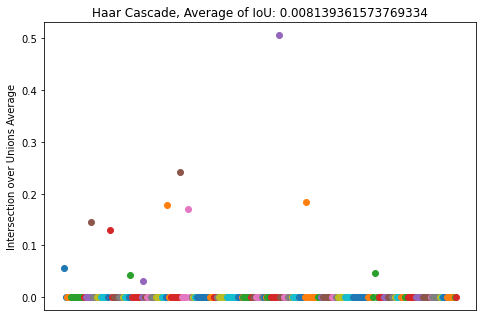

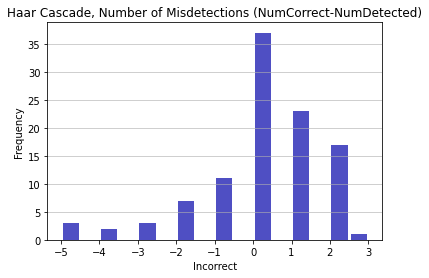

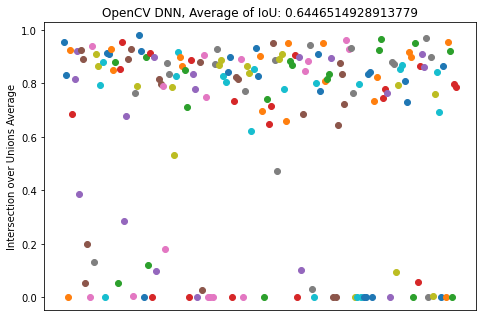

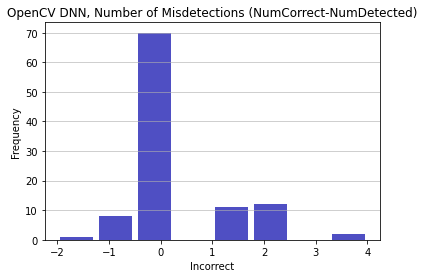

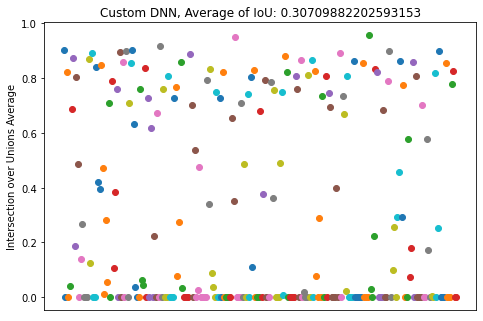

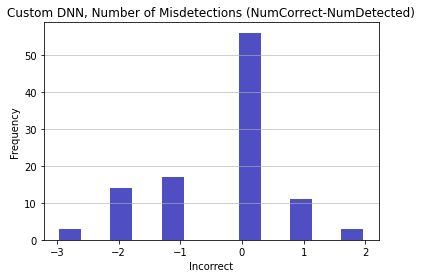

In [24]:
group = "Couple"
data = get_data(group, path)

fbb_cascade = prebuilt_cascade(data)
fbb_dnn = prebuilt_dnn(data, prototxtPath, weightsPath)
fbb_dnn2 = custom_cnn(data, saved_model_path)
# fbb_c_cascade = custom_cascade(data)
# fbb_s_cascade = strict_cascade(data)

result_cascade = tester2(data, fbb_cascade)
result_dnn = tester2(data, fbb_dnn)
result_dnn2 = tester2(data, fbb_dnn2)
# result_c_cascade = tester2(data, fbb_c_cascade)
# result_s_cascade = tester2(data, fbb_s_cascade)

plot_results(result_cascade, "Haar Cascade")
plot_results(result_dnn, "OpenCV DNN")
plot_results(result_dnn2, "Custom DNN")
# plot_results(result_c_cascade, "Custom Cascade")
# plot_results(result_s_cascade, "Strict Cascade")

### Inspect sample images from DNN Classification

In [ ]:
for i in range(0, len(result_dnn)):
    if result_dnn[i][2] > result_dnn[i][3] :
        image = cv2.imread(result_dnn[i][0],cv2.IMREAD_COLOR)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        plt.title("image name: {}".format(result_dnn[i][0] + ", num: {}".format(result_dnn[i][3])) + "({})".format(result_dnn[i][2]))
        plt.show()

## Dataset: Custom

69.92607712745667
14.28897476196289
INFO:tensorflow:Restoring parameters from /Users/james/Downloads/lightweight_face_detector-master/lightweight_face_detector-master/checkpoints/fast_mode_enable_hflip\variables\variables
106.3875961303711
130.44824719429016


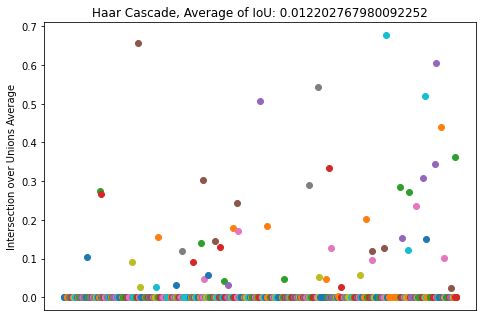

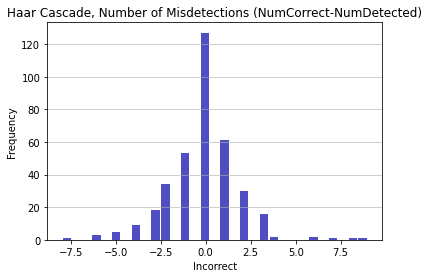

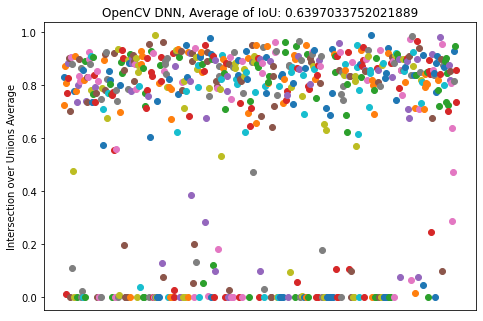

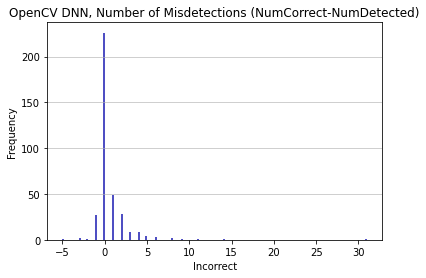

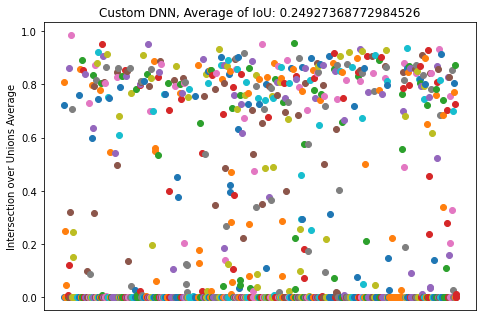

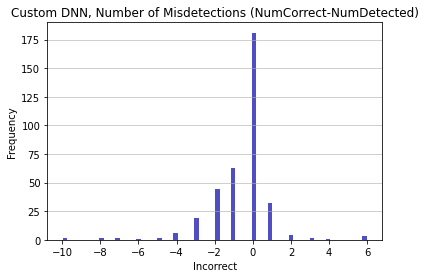

c:\users\james\anaconda3\envs\tensorflow\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\james\anaconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


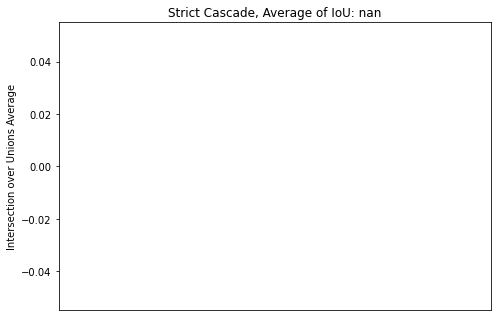

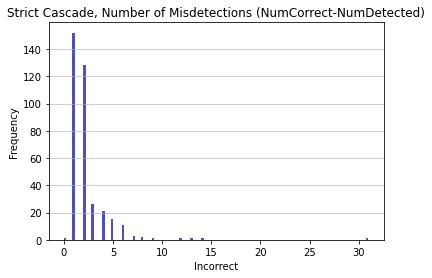

In [11]:

group = "Demonstration"
data = get_data(group, path)
data = data + get_data("Couple", path) + get_data("Concerts", path)
start = time.time()
fbb_cascade = prebuilt_cascade(data)
end = time.time()
print(end - start)

start = time.time()
fbb_dnn = prebuilt_dnn(data, prototxtPath, weightsPath)
end = time.time()
print(end - start)

start = time.time()
fbb_dnn2 = custom_cnn(data, saved_model_path)
end = time.time()
print(end - start)

# fbb_c_cascade = custom_cascade(data)
start = time.time()
fbb_s_cascade = strict_cascade(data)
end = time.time()
print(end - start)

result_cascade = tester2(data, fbb_cascade)
result_dnn = tester2(data, fbb_dnn)
result_dnn2 = tester2(data, fbb_dnn2)
# result_c_cascade = tester2(data, fbb_c_cascade)
result_s_cascade = tester2(data, fbb_s_cascade)

plot_results(result_cascade, "Haar Cascade")
plot_results(result_dnn, "OpenCV DNN")
plot_results(result_dnn2, "Custom DNN")
# plot_results(result_c_cascade, "Custom Cascade")
plot_results(result_s_cascade, "Strict Cascade")